In [1]:
import pandas as pd
import numpy as np

dtypeDict = {'opted_in_to_mailing_list': np.float64,
             'enabled_for_marketing_drip': np.float64,
             'creation_source': 'category'}

#reads in data from csv, makes object id the index, parses the date for creation time, and some dtypes are specified from the dict above
df = pd.read_csv('takehome_users.csv', encoding='latin-1', index_col='object_id', parse_dates=['creation_time'], dtype=dtypeDict)
df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1.0,0.0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0.0,0.0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0.0,0.0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0.0,0.0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0.0,0.0,193,5240.0


In [2]:
#loads login log into another dataframe
df_logs = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
df_logs.head()

#groups all the logins by user ID and makes a list of all login dates
df_logs = pd.pivot_table(df_logs, index=['user_id'], values=['time_stamp'], aggfunc=lambda x:list(x))
df_logs.head()

,time_stamp
user_id,
1,[2014-04-22 03:53:30]
2,"[2013-11-15 03:45:04, 2013-11-29 03:45:04, 201..."
3,[2013-03-19 23:14:52]
4,[2013-05-22 08:09:28]
5,[2013-01-22 10:14:20]


In [3]:
#function that creates time delta between the login 2 interation ahead if applicable
def createTimeDeltas(timeStampList):
    listLen = len(timeStampList)
    timeDeltaList = []
    
    if listLen > 2:
        
        for idx in range(listLen-2):
            timeDelta = (timeStampList[idx+2] - timeStampList[idx]).days
            timeDeltaList.append(timeDelta)
        
    return timeDeltaList

#determines if user is adopted if their time delta between first and last logins in a group of three is less than 7 days
def isAdoptedUser(timeStampList):
    timeDeltaList = createTimeDeltas(timeStampList)
    if any(timeDelta <= 7 for timeDelta in timeDeltaList):
        return np.float64(1.0)
    else:
        return np.float64(0.0)

In [4]:
#applies funtion above. Also creates column of total number of logins
df_logs['adopted_user'] = df_logs.time_stamp.apply(isAdoptedUser)
df_logs['total_number_of_logins'] = df_logs.time_stamp.apply(len)
df_logs.head()

,time_stamp,adopted_user,total_number_of_logins
user_id,,,
1,[2014-04-22 03:53:30],0.0,1
2,"[2013-11-15 03:45:04, 2013-11-29 03:45:04, 201...",1.0,14
3,[2013-03-19 23:14:52],0.0,1
4,[2013-05-22 08:09:28],0.0,1
5,[2013-01-22 10:14:20],0.0,1


In [5]:
#does a SQL style left join, since some users never logged in
df = df.merge(df_logs,'left', left_index=True, right_index=True)
df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,adopted_user,total_number_of_logins
object_id,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1.0,0.0,11,10803.0,[2014-04-22 03:53:30],0.0,1.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0.0,0.0,1,316.0,"[2013-11-15 03:45:04, 2013-11-29 03:45:04, 201...",1.0,14.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0.0,0.0,94,1525.0,[2013-03-19 23:14:52],0.0,1.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0.0,0.0,1,5151.0,[2013-05-22 08:09:28],0.0,1.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0.0,0.0,193,5240.0,[2013-01-22 10:14:20],0.0,1.0


In [6]:
#Creates columns of how many users are in the organization their in
orgMemberCountMapping = df.org_id.value_counts().to_dict()
df['org_size'] = df.org_id.map(orgMemberCountMapping).astype(np.float64)

The following cells impute values for column with null values

In [7]:
#converts creation time from datetime to int unix time to a float64 of the unix time
df['creation_time'] = (df.creation_time.astype(np.int64) // 10**9).astype(np.float64)

In [8]:
#imputes creation time to last sessions time if the user never logged in
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(df.creation_time)

In [9]:
# fills empty lists for null time_stamps, however, this columns will not be used later
df['time_stamp'] = df['time_stamp'].apply(lambda d: d if isinstance(d, list) else [])

In [10]:
df['time_between_creation_first_login'] = (pd.to_datetime(df['time_stamp'].apply(lambda x: x[0] if x else np.nan)).astype(np.int64) // 10**9).astype(np.float64) - df['creation_time']

In [11]:
#fills in 0.0 for users who never logged in
df['adopted_user'] = df['adopted_user'].fillna(np.float64(0.0))

In [12]:
#fills in 0.0 for users who never logged in
df['total_number_of_logins'] = df['total_number_of_logins'].fillna(np.float64(0.0))

In [13]:
#changes dtype of org_id to float64
df['org_id'] = df['org_id'].astype(np.float64)

In [14]:
df['invited'] = df.invited_by_user_id.apply(lambda x: 0.0 if np.isnan(x) else 1.0)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 15 columns):
creation_time                        12000 non-null float64
name                                 12000 non-null object
email                                12000 non-null object
creation_source                      12000 non-null category
last_session_creation_time           12000 non-null float64
opted_in_to_mailing_list             12000 non-null float64
enabled_for_marketing_drip           12000 non-null float64
org_id                               12000 non-null float64
invited_by_user_id                   6417 non-null float64
time_stamp                           12000 non-null object
adopted_user                         12000 non-null float64
total_number_of_logins               12000 non-null float64
org_size                             12000 non-null float64
time_between_creation_first_login    12000 non-null float64
invited                              12000 non-null fl

In [16]:
df.adopted_user.value_counts()

0.0    10344
1.0     1656
Name: adopted_user, dtype: int64

In [17]:
#remove columns that give away answers, as well as the target, then split data in to training and testing sets
X = df.drop(['adopted_user','invited_by_user_id', 'name','email','invited_by_user_id','time_stamp', 'org_id', ''], axis=1)
Y = df['adopted_user']
#view dataframe to be used
X

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,total_number_of_logins,org_size,time_between_creation_first_login,invited
object_id,,,,,,,,,
1,1.398139e+09,GUEST_INVITE,1.398139e+09,1.0,0.0,1.0,75.0,0.0,1.0
2,1.384487e+09,ORG_INVITE,1.396238e+09,0.0,0.0,14.0,233.0,0.0,1.0
3,1.363735e+09,ORG_INVITE,1.363735e+09,0.0,0.0,1.0,32.0,0.0,1.0
4,1.369124e+09,GUEST_INVITE,1.369210e+09,0.0,0.0,1.0,233.0,86400.0,1.0
5,1.358418e+09,GUEST_INVITE,1.358850e+09,0.0,0.0,1.0,16.0,432000.0,1.0
...,...,...,...,...,...,...,...,...,...
11996,1.378448e+09,ORG_INVITE,1.378448e+09,0.0,0.0,1.0,40.0,0.0,1.0
11997,1.357843e+09,SIGNUP_GOOGLE_AUTH,1.358275e+09,0.0,0.0,1.0,25.0,432000.0,0.0
11998,1.398603e+09,GUEST_INVITE,1.398603e+09,1.0,1.0,1.0,27.0,0.0,1.0


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

#split data in to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

#columns to be stardard scaled
numeric_features = ['creation_time',
                    'last_session_creation_time',
                    'org_size',
                    'time_between_creation_first_login',
                    'total_number_of_logins']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

#Columns to one hot encoded
categorical_features = ['creation_source']

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

#building the column transformer with both transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
         remainder='passthrough')

#fit the preprocessor, then transform trainging and test set, assign sparse matrix to variables
preprocessor.fit(X)
encX_train = preprocessor.transform(X_train)
encX_test = preprocessor.transform(X_test)

In [19]:
def get_column_names_from_ColumnTransformer(column_transformer, remainder_dict):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif (isinstance(names,list) and isinstance(names[0],int)):
            for name in names:
                col_name.append(remainder_dict[name])
        elif isinstance(names,list):
            col_name += names
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

remainder_dict = {3:'opted_in_to_mailing_list',
                  4:'enabled_for_marketing_drip',
                  8:'invited'}

processedColumns = get_column_names_from_ColumnTransformer(preprocessor, remainder_dict)

In [20]:
processedColumns

['creation_time',
 'last_session_creation_time',
 'org_size',
 'time_between_creation_first_login',
 'total_number_of_logins',
 'x0_GUEST_INVITE',
 'x0_ORG_INVITE',
 'x0_PERSONAL_PROJECTS',
 'x0_SIGNUP',
 'x0_SIGNUP_GOOGLE_AUTH',
 'opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'invited']

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def graphFeatureImportance(bestfit, processedColumns, modelName, isCoef = False):

    if isCoef:
        coef_df = pd.DataFrame([processedColumns,list(bestfit.coef_[0])]).transpose().sort_values(1, ascending=False)
    else:
        coef_df = pd.DataFrame([processedColumns,list(bestfit.feature_importances_)]).transpose().sort_values(1, ascending=False)
    
    x = coef_df[0]
    y = coef_df[1]
    
    plt.figure(figsize=(7,3))
    plt.bar(x,y)
    plt.title('Feature Importance for '+ modelName)
    plt.xticks(rotation=85)
    plt.xlabel('Features')
    if isCoef:
        plt.ylabel('Coefficient')
    else:
        plt.ylabel('"Importance"')
    plt.show()

Best model was:
 LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 
which recieved an accuracy score of:  0.9825
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3111
         1.0       0.92      0.96      0.94       489

    accuracy                           0.98      3600
   macro avg       0.96      0.97      0.96      3600
weighted avg       0.98      0.98      0.98      3600



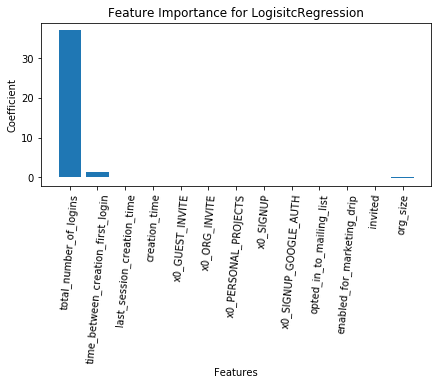

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

lr = LogisticRegression(solver= 'liblinear')
lr_para = {'C':[1.0,0.1,0.01], 
           'class_weight':[None,'balanced'],
           'max_iter':[50,100,150],
           'penalty': ['l1','l2']}

#Apply grid search with above parameters specified
fitmodel = GridSearchCV(lr, lr_para,cv=5, scoring='accuracy', n_jobs=-1)
fitmodel.fit(encX_train,y_train)

#store the best fitting LogisiticRegression(), create prediciton from X_test data
bestfitLR = fitmodel.best_estimator_

bestfitLR.fit(encX_train,y_train)
y_pred = bestfitLR.predict(encX_test)
print('Best model was:\n', bestfitLR, '\nwhich recieved an accuracy score of: ', bestfitLR.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

graphFeatureImportance(bestfitLR, processedColumns, 'LogisitcRegression', True)

Best model was:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
which recieved an accuracy score of:  0.9838888888888889
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3111
         1.0       0.95      0.93      0.94       489

    accuracy                           0.98      3600
   macro avg       0.97      0.96      0.97      3600
weighted avg       0.98      0.98      0.98      3600



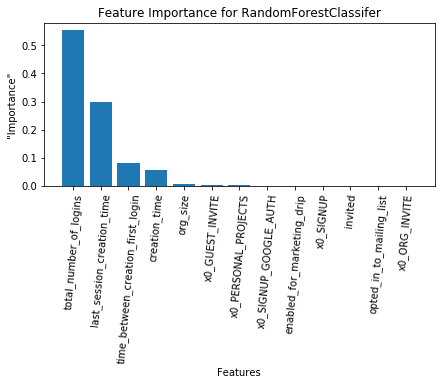

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#define classifier and parameter grid
rf = RandomForestClassifier()
forest_para = {'criterion':['gini','entropy'],
                'min_samples_split' : range(2,6,2),
                'max_depth': range(3,7,2),
                'n_estimators':range(10,30,10)}

#Grid search to find best hyper parameters
fitmodel = GridSearchCV(rf,forest_para,cv=5, scoring='roc_auc')
fitmodel.fit(encX_train,y_train)

#store the best fitting LogisiticRegression(), create prediciton from X_test data
bestfitRF = fitmodel.best_estimator_

bestfitRF.fit(encX_train,y_train)
y_pred = bestfitRF.predict(encX_test)
print('Best model was:\n', bestfitRF, '\nwhich recieved an accuracy score of: ', bestfitRF.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

graphFeatureImportance(bestfitRF, processedColumns, 'RandomForestClassifer')

Best model was:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='exponential', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) 
which recieved an accuracy score of:  0.9858333333333333
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3111
         1.0       0.95      0.94      0.95       489

    accuracy                           0.99      3600
   macro avg       0.97    

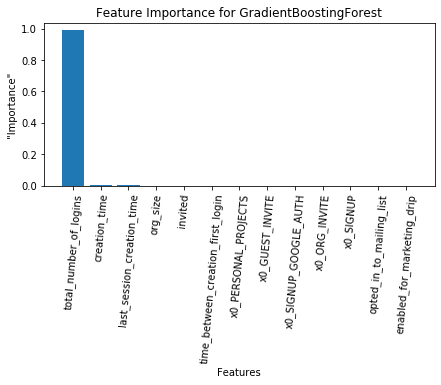

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc_para = {'loss':['deviance', 'exponential'],
            'learning_rate': [0.1, 0.05],
            'max_depth': [3,7]}

#Apply grid search with above parameters specified
fitmodel = GridSearchCV(gbc, gbc_para,cv=5, scoring='roc_auc', n_jobs=-1)
fitmodel.fit(encX_train,y_train)

#store the best fitting GradientBoostingClassifier(), create prediciton from X_test data
bestfitGBC = fitmodel.best_estimator_

bestfitGBC.fit(encX_train,y_train)
y_pred = bestfitGBC.predict(encX_test)
print('Best model was:\n', bestfitGBC, '\nwhich recieved an accuracy score of: ', bestfitGBC.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

graphFeatureImportance(bestfitGBC, processedColumns, 'GradientBoostingForest')

Best model was:
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False) 
which recieved an accuracy score of:  0.9825
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3111
         1.0       0.97      0.90      0.93       489

    accuracy                           0.98      3600
   macro avg       0.98      0.95      0.96      3600
weighted avg       0.98      0.98      0.98      3600



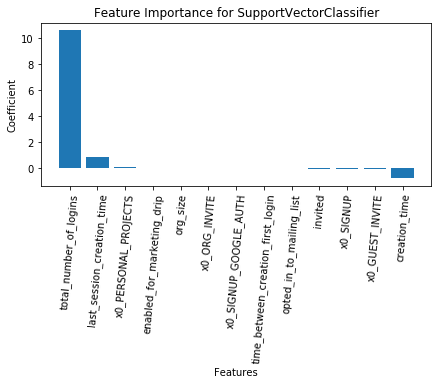

In [25]:
from sklearn.svm import SVC

svc= SVC()
svc_para = {'C':[1.0,0.1,0.01], 
           'class_weight':[None,'balanced'],
           'max_iter':[50,100,-1],
           'kernel': ['rbf','linear','poly']}

#Apply grid search with above parameters specified
fitmodel = GridSearchCV(svc, svc_para,cv=5, scoring='accuracy', n_jobs=-1)
fitmodel.fit(encX_train,y_train)

#store the best fitting LogisiticRegression(), create prediciton from X_test data
bestfitSVC = fitmodel.best_estimator_

bestfitSVC.fit(encX_train,y_train)
y_pred = bestfitSVC.predict(encX_test)
print('Best model was:\n', bestfitSVC, '\nwhich recieved an accuracy score of: ', bestfitSVC.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

if bestfitSVC.get_params()['kernel'] == 'linear':
    graphFeatureImportance(bestfitSVC, processedColumns, 'SupportVectorClassifier', True)